## **Exploring the Social Dynamics of Reddit**  
**02805 Social Graphs & Interactions**  

**Group 13** 
- Anna Bøgevang Ekner (s193396)
- Morten Møller Christensen (s204258)


Our project **Exploring the Social Dynamics of Reddit** explores the interplay between community structures and sentiment patterns on Reddit, addressing key questions about the internal engagement within subreddits, their interconnections, and the emotional tone of discussions. This explainer notebook will walk you through our analysis of the Reddit graph using network science and sentiment analysis. 

In [1]:
import os
import praw
import json
import random
import nltk
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from joypy import joyplot
from PIL import Image
from tqdm import tqdm
from afinn import Afinn
from itertools import count
from dotenv import load_dotenv
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from scipy.stats import linregress
from collections import Counter
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, HTML

sns.set_style('darkgrid')
sns.set(font_scale=1.)

c:\Users\morte\anaconda3\envs\Cuda\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## **Part 1: Retrieving the data**

In the first part of the project, the data for creating the graph is retrieved through the Reddit API. 

#### **Part 1.1: Setting up the Reddit API**

The Reddit API is initialized through our private tokens, and can then be used to extract data directly from Reddit without having to scrape it.

In [7]:
def load_API_tokens():
    # Load environment variables from the .env file
    load_dotenv()

    # Retrieve tokens from environment variables
    client_id = os.getenv('CLIENT_ID')
    client_secret = os.getenv('CLIENT_SECRET')
    user_agent = os.getenv('USER_AGENT')

    return client_id, client_secret, user_agent

In [8]:
# Load API tokens
client_id, client_secret, user_agent = load_API_tokens()

# Initialize Reddit instance with credentials from the .env file
reddit = praw.Reddit(
    client_id=client_id,
    client_secret=client_secret,
    user_agent=user_agent
)

#### **Part 1.2: Retrieving and saving the data**

To retrieve the data we first sample **50 random subreddits**, each with at least **100.000 subscribers**. For each subreddit we retrieve the **20 most upvoted posts from the past year**, witth the constraint that posts without text are skipped. The data was retrived ***08-11-2024***. For every post we save the first layer of comments i.e. the comments directly replying to the post. This means that the number of comments saved for each post varies.
An example of the data structure is shown below:

```bash
├── Subreddit_1
│   ├── Post_1
│   │   ├── Comment_1
│   │   ├── Comment_2
│   │   ├── ...
│   │   └── Comment_n
│   ├── Post_2
│   ├── ...
│   └── Post_20
└──
```

*Note that although we are fully aware that the data won't be representative of the entire Reddit network, we believe that the gathered data will be sufficient for our analysis. In order to have a more representative dataset, we would have to sample a larger number of subreddits and posts, which would require more resources than we have available.*

For each of the randomly selected subreddits, a `.json` file with the following information was saved for later creating the graph. All of this information is stored to later use in the exploratory analysis.

| **Category**        | **Field**       | **Description**                  |
|---------------------|-----------------|-----------------------------------|
| **Subreddit info**  | Subreddit       | The name of the subreddit.       |
|                     | Description    | Brief description of the subreddit. |
|                     | Subscribers    | Number of subscribers.           |
| **Post info**       | Title          | Title of the post.               |
|                     | Author         | Username of the post author.     |
|                     | Score          | Number of upvotes of the post. |
|                     | Text           | The content or body of the post. |
|                     | Subreddit      | Subreddit the post belongs to.   |
|                     | URL            | Direct link to the post.         |
|                     | ID             | Unique identifier for the post.  |
| **Comment info**    | Comment ID             | Unique identifier for the comment. |
|                     | Author         | Username of the comment author.     |
|                     | Body           | The content or body of the comment. |
|                     | Score          | Number of upvotes of the comment. |


An example of a `.json` file can be seen below.


![example-json](images/example-json.png)

In [9]:
def retrieve_reddit_data(n_subreddits, n_posts_per_subreddit, min_subscribers, top_all, data_dir):
    """
    Retrieve Reddit data for a given number of random subreddits and save the data to JSON files.

    For {n_subreddits} random subreddits with at least {min_subscribers} subscribers, scrapes the 
    top {n_posts_per_subreddit} posts and comments from the past year and saves the data to JSON files.

    Args 
        n_subreddits: Number of random subreddits to fetch (int)
        n_posts_per_subreddit: Number of top posts to fetch per subreddit (int)
        min_subscribers: Minimum number of subscribers for a subreddit to be included (int)
        top_all: Time frame for top posts (e.g., 'all', 'year', 'month', 'week', 'day', 'hour')
        data_dir: Directory to save the JSON files (str)
    """

    # Number of subreddit JSON files already saved
    saved_subreddits = len(os.listdir(data_dir))

    os.makedirs(data_dir, exist_ok=True)

    while saved_subreddits < n_subreddits:

        # Fetch a random subreddit and validate its subscriber count
        random_subreddit = reddit.subreddit("random")
        
        if random_subreddit.subscribers < min_subscribers:
            continue

        print(f"Selected subreddit: {random_subreddit.display_name} with {random_subreddit.subscribers} subscribers")

        # Fetch top posts and initialize data structure
        limit = n_posts_per_subreddit * 1000
        top_posts = random_subreddit.top(top_all, limit=limit)

        subreddit_data = {
            "subreddit": random_subreddit.display_name,
            "description": random_subreddit.public_description,
            "subscribers": random_subreddit.subscribers,
            "posts": []
        }

        # Counter for the number of posts without empty text
        saved_posts = 0

        while saved_posts < n_posts_per_subreddit and len(subreddit_data["posts"]) < n_posts_per_subreddit:

            # Get the next top post
            post = next(top_posts)

            # Skip posts with empty text
            if not post.selftext.strip():
                continue

            post_data = {
                "title": post.title,
                "author": post.author.name if post.author else "deleted",
                "score": post.score,
                "text": post.selftext,
                "subreddit": post.subreddit.display_name,
                "url": post.url,
                "id": post.id,
                "comments": []
            }

            # Fetch up to 10 comments per post
            post.comments.replace_more(limit=0)
            post_data["comments"] = [
                {
                    "comment_id": comment.id,
                    "author": comment.author.name if comment.author else "deleted",
                    "body": comment.body,
                    "score": comment.score
                }
                for comment in post.comments.list()
            ]

            saved_posts += 1
            subreddit_data["posts"].append(post_data)

        # Save subreddit data to a JSON file
        file_path = os.path.join(data_dir, f"{random_subreddit.display_name}.json")
        with open(file_path, "w", encoding="utf-8") as f:
            json.dump(subreddit_data, f, indent=4)

        print(f"Data saved to {file_path}\n")
        saved_subreddits += 1

In [10]:
# Retrieve and save Reddit data
retrieve_reddit_data(n_subreddits = 50, 
                     n_posts_per_subreddit = 20, 
                     min_subscribers = 100000,
                     top_all = "year", 
                     data_dir = "data")

## **Part 2: Building the graph**

Now that the data has been retrieved and saved as `.json` files, it is time to build the Reddit graph. The nodes of the graph are individual posts identified by their unique identifier `ID`, and a link between two posts is made if the same user has commented on both. Each node has a subset of the saved post information as associated attributes, namely: 

- `title`: Title of the post
- `author`: Username of the post author
- `text`: The content or body of the post
- `score`: The number of upvotes of the post
- `subreddit`: Subreddit the post belongs to
- `subreddit_subscribers`: Number of subscribers of the subreddit the post belongs to
- `comments`: The comments of the post

After adding all 20 posts of each of the 50 subreddits as nodes to the graph (i.e. 1000 nodes), links were created between nodes through shared commenters. Comments were discarded, and therefore not considered for links, if the author was identified to be either `deleted` (indicating a deleted comment) or `AutoModerator` (indicating an automatic moderation comment).

Lastly, after building the graph, only the largest connected component is returned as the final graph in order to exclude isolated notes. 

In [11]:
def create_graph(data_dir):
    """
    Build the Reddit undirected graph from the scraped data. Nodes are posts, and a 
    link between two nodes is created when the same user comments on both posts.

    Args
        data_dir: Directory containing the subreddit JSON files (str)

    Returns 
        G: Undirected graph representing the Reddit network (nx.Graph)
    """

    # Initialize the graph
    G = nx.Graph()

    # Add nodes for each post
    for file_name in os.listdir(data_dir):
        with open(os.path.join(data_dir, file_name), "r", encoding="utf-8") as f:
            subreddit_data = json.load(f)
        
        for post in subreddit_data["posts"]:
            # Limit the number of comments to reduce the number of edges
            limited_comments = post["comments"]#[:200]
            G.add_node(post["id"], 
                       title = post["title"], 
                       author = post["author"],
                       score = post["score"],
                       subreddit = post["subreddit"], 
                       subreddit_subscribers = subreddit_data["subscribers"],
                       text = post["text"], 
                       comments = limited_comments)

    # List of all nodes
    nodes_list = list(G.nodes(data=True))

    common_commenters_within = 0
    common_commenters_across = 0

    # Add links based on shared commenters
    for i, post1 in enumerate(nodes_list):
        for post2 in nodes_list[i+1:]:

            # Get the comments for each post
            post1_comments = post1[1]["comments"]
            post2_comments = post2[1]["comments"]

            # Get the usernames of the commenters for each post
            post1_commenters = set(comment["author"] for comment in post1_comments)
            post2_commenters = set(comment["author"] for comment in post2_comments)
            
            # Remove "deleted" from the sets
            post1_commenters.discard("deleted")
            post2_commenters.discard("deleted")

            post1_commenters.discard("AutoModerator")
            post2_commenters.discard("AutoModerator")

            # Find the common commenters between the two posts
            common_commenters = set(post1_commenters).intersection(post2_commenters)

            if common_commenters:
                G.add_edge(post1[0], post2[0])

                if post1[1]['subreddit'] == post2[1]['subreddit']:
                    common_commenters_within += 1
                else:
                    common_commenters_across += 1

    # Find the largest connected component
    largest_cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(largest_cc).copy()

    print(f"Number of common commenters within the same subreddit: {common_commenters_within}")
    print(f"Number of common commenters across different subreddits: {common_commenters_across}")
    
    return G

In [12]:
# Create the Reddit graph
G = create_graph("data")

Number of common commenters within the same subreddit: 7206
Number of common commenters across different subreddits: 13646


While building the graph, it is seen that there is a total of 7206 links between nodes **within the same subreddit**, whereas there is a total of 13646 links between nodes **across different subreddits**. This suggests that there are strong interconnections both within and between subreddits.

## **Part 3: Analyzing network structures**

Time to start exploring the Reddit graph! In the next part, we will do a preliminary analysis of the network. The analysis will include:
* Number of nodes and edges
* Degree distribution
    * Average degree within subreddits
* Topological measures
    * Shortest path
    * Degree centrality vs. closeness centrality



#### **Part 3.1: Nodes and edges**

The first and simplest thing to do is to check the number of nodes and edges in the graph. This will give us an idea of the size of the network and how connected it is.

In [13]:
N = G.number_of_nodes()
L = G.number_of_edges()
k_avg = 2 * L / N

print(f"Total number of nodes: {N}")
print(f"Total number of links: {L}")
print(f"Average degree of nodes: {k_avg:.2f}")

Total number of nodes: 998
Total number of links: 20851
Average degree of nodes: 41.79


The Reddit graph has $N = 998$ nodes connected by $L = 20851$ links. Hence by extracting only the largest connected component, only 2 of the 1000 posts have no connections to other posts, and were therefore not included in the final graph. The average degree is $⟨k⟩ = 41.79$, meaning that every post is on average connected to $\approx 42$ other posts through shared commenters. Coincidence? I think not. 🤨

![images/42.png](images/42.png)

#### **Part 3.2: Degree distribution**

Now, we investigate which posts are the most and least connected in the network.

**Most and least connected posts**

In [14]:
def display_scrollable_dataframes(df1, header1, df2=None, header2=None, max_height=500):
    """ 
    Display one or two pandas DataFrames side by side in a scrollable format.
    """
    
    if df2 is not None and header2 is not None:
        display(HTML(f"""
        <style>
            .dataframe th, .dataframe td {{
                text-align: left;
            }}
        </style>
        <div style="display: flex;">
            <div style="max-height: {max_height}px; overflow-y: auto; padding: 5px; width: 50%;">
                <h3>{header1}</h3>
                {df1.to_html(index=False)}
            </div>
            <div style="max-height: {max_height}px; overflow-y: auto; padding: 5px; width: 50%;">
                <h3>{header2}</h3>
                {df2.to_html(index=False)}
            </div>
        </div>
        """))
    else:
        display(HTML(f"""
        <style>
            .dataframe th, .dataframe td {{
                text-align: left;
            }}
        </style>
        <div style="max-height: {max_height}px; overflow-y: auto; padding: 5px; width: 100%;">
            <h3>{header1}</h3>
            {df1.to_html(index=False)}
        </div>
        """))

In [15]:
# Set the number of top nodes to print
n = 5 

# Get the top n nodes
top_n_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:n]
lowest_n_nodes = sorted(G.degree, key=lambda x: x[1], reverse=False)[:n]

# Convert to pandas
df_top_n_nodes = pd.DataFrame({'Degree': [degree for _, degree in top_n_nodes],
                               'Subreddit': [G.nodes[node]['subreddit'] for node, _ in top_n_nodes],
                               'Title': [G.nodes[node]['title'] for node, _ in top_n_nodes]})

df_lowest_n_nodes = pd.DataFrame({'Degree': [degree for _, degree in lowest_n_nodes],
                                  'Subreddit': [G.nodes[node]['subreddit'] for node, _ in lowest_n_nodes],
                                  'Title': [G.nodes[node]['title'] for node, _ in lowest_n_nodes]})

# Display the top n nodes
display_scrollable_dataframes(df_top_n_nodes, "Top 5 most connected nodes", 
                              df_lowest_n_nodes, "Top 5 least connected nodes")

Degree,Subreddit,Title
135,HydroHomies,A doctor gave me this at work today
126,tifu,TIFU by telling my roommate to drop his Japanese fetish.
125,Showerthoughts,Tik Tok by Kesha is going to be really weird for younger people.
123,brooklynninenine,least favourite cameos?
123,tifu,TIFU by not telling my doctor how many Tic-Tacs I eat per day
Degree,Subreddit,Title
1,help,Cannot leave a subreddit.
1,legaladvice,I am schizophrenic. Someone filmed me having a bad episode and shared it on TikTok.
1,MakeNewFriendsHere,Guyzz warning to all of youuu
2,DecidingToBeBetter,I will do one push up for every UPVOTE this post generates!


The most connected nodes in the network have degrees above 120, indicating they are connected to ~12\% of the other nodes in the network. Most notably is that the subreddit `tifu` (short for Today I Fucked Up) has two posts among the top 5, one of them with the title *"TIFU by not telling my doctor how many Tic-Tacs I eat per day"*. This sparked our interest, so we looked it up. TL;DR, the guy ate 200-400 Tic Tacs a day, because (in his own words): *"on the nutrition label, it says the serving size is 1 candy, and is listed as having 0 calories, which I thought was awesome because I could have as many as I want!"*

The least connected nodes in the network includes three nodes with a degree of 1, meaning they are only connected to a single other node. Amongst the top 5 least connected nodes in the network, there are two posts from the subreddit `DecidingToBeBetter`. 

**Histogram of degree distribution**

Next we examine the degree distribution of the network. The distribution gives us an idea about how many nodes have a certain degree.

In [16]:
def plot_degree_distribution(G):
    """ 
    Plot the degree distribution of the Reddit network.

    Args
        G: Undirected graph representing the Reddit network (nx.Graph)
    """

    # Degrees in the graph
    degrees = [G.degree(n) for n in G.nodes()]
    bin_edges = np.linspace(0, max(degrees), max(degrees) + 1)

    # Average degree
    avg_degree = np.mean(degrees)

    # Binning the data 
    counts, bin_edges = np.histogram(degrees, bins=bin_edges)

    plt.figure(figsize=(8, 6))
    plt.bar(bin_edges[:-1], counts, width=1, label='Degree distribution', color='cornflowerblue')
    plt.axvline(avg_degree, color='g', linestyle='--', label=f'Average degree: {avg_degree:.2f}')
    plt.xlim(0, max(degrees))
    plt.xlabel('Degree')
    plt.ylabel('Number of nodes')
    plt.title('Reddit network degree distribution')
    plt.legend()
    plt.tight_layout()
    plt.show()

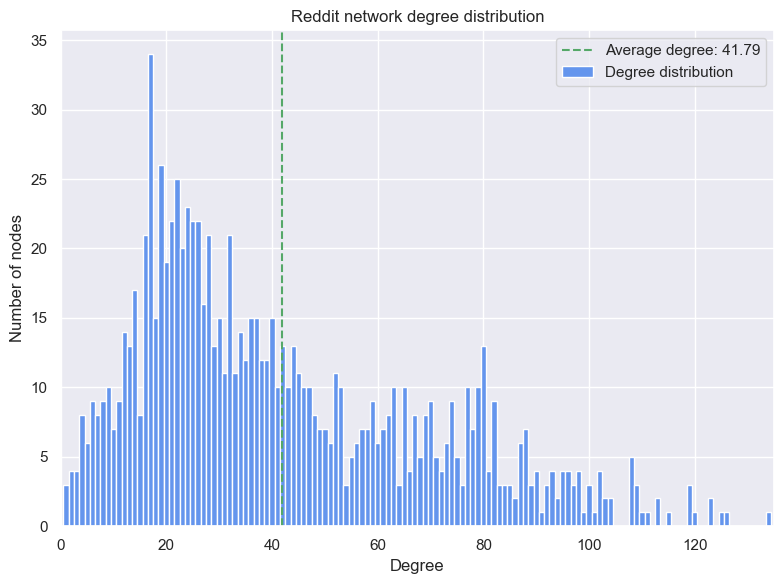

In [17]:
# Plot the degree distribution
plot_degree_distribution(G)

Looking at the entire degree distribution, we see that it does not follow a power-law distribution. The distribution is right-skewed meaning that most nodes have a low degree, but a few nodes with high degrees exist. In the tail of the distribution, we see the posts listed earlier, i.e. posts like *"A doctor gave me this at work today"* and *"TIFU by not telling my doctor how many Tic-Tacs I eat per day"*.

**Average degree within subreddits**

To further analyze distribution of degrees within the network, we investigated the average degree of nodes in each subreddit. Our hypothesis was that the most connected nodes would predominantly belong to the largest subreddits, as posts in larger subreddits are more likely to connect with other posts due to their higher number of subscribers and active commenters. To test this hypothesis, we therefore plotted each subreddit as a point with the x-axis representing its number of subscribers and the y-axis representing its average degree of the nodes within this subreddit. Then we assessed the correlation between these two variables with a linear regression fit. Additionally, each point was colored according to the average number of upvotes within the subreddit, which could also be indicative of the average degree of the nodes within the subreddit and/or number of subscribers.

In [18]:
def compute_average_degree_subreddits(G):
    """
    Compute the average degree of the nodes in each subreddit.

    Args
        G: undirected graph of Reddit posts (nx.Graph)

    Returns
        average_degree: dictionary of all subreddits, where keys are subreddits 
        and values the average degree of the nodes in the subreddit.
    """
    
    # Get all subreddits present in the graph
    all_subreddits = set(nx.get_node_attributes(G, 'subreddit').values())

    # Dictionary for the average degree with each subreddit as key
    average_degree = {subreddit: [] for subreddit in all_subreddits}

    for node in G.nodes():

        # Get subreddit of the node
        subreddit = G.nodes[node]['subreddit']

        # Get the degree of the node
        degree = G.degree[node]

        # Append the degree to the subreddit list
        average_degree[subreddit].append(degree)

    # Compute the average degree for each subreddit
    for subreddit in average_degree:
        average_degree[subreddit] = np.mean(average_degree[subreddit])

    return average_degree

def get_subscribers_subreddits(G):
    """
    Get the number of subscribers for each subreddit in the graph.

    Args
        G: undirected graph of Reddit posts (nx.Graph)

    Returns
        subscribers: dictionary of all subreddits, where keys are subreddits 
        and values the number of subscribers of the subreddit.
    """

    # Get all subreddits present in the graph
    all_subreddits = set(nx.get_node_attributes(G, 'subreddit').values())

    # Dictionary for the number of subscribers with each subreddit as key
    subscribers = {subreddit: 0 for subreddit in all_subreddits}

    for node in G.nodes():

        # Get subreddit of the node
        subreddit = G.nodes[node]['subreddit']

        # Get the number of subscribers of the subreddit
        subscribers[subreddit] = G.nodes[node]['subreddit_subscribers']

    return subscribers

def get_upvotes_subreddits(G):
    """
    Get the average number of upvotes for each subreddit in the graph.

    Args 
        G: undirected graph of Reddit posts (nx.Graph)
    
    Returns 
        upvotes: dictionary of all subreddits, where keys are subreddits
        and values the average number of upvotes of the posts in the subreddit.
    """

    # Get all subreddits present in the graph
    all_subreddits = set(nx.get_node_attributes(G, 'subreddit').values())

    # Dictionary for the number of upvotes with each subreddit as key
    upvotes = {subreddit: [] for subreddit in all_subreddits}

    for node in G.nodes():
            
            # Get subreddit of the node
            subreddit = G.nodes[node]['subreddit']

            # Get the number of upvotes of the node
            upvotes[subreddit].append(G.nodes[node]['score'])

    # Compute the average number of upvotes for each subreddit
    for subreddit in upvotes:
        upvotes[subreddit] = np.mean(upvotes[subreddit])
    
    return upvotes


def plot_degree_subscribers(average_degree, subscribers, upvotes):
    """
    Plot the average degree of the nodes in each subreddit against the number of subscribers.

    Args
        G: undirected graph of Reddit posts (nx.Graph)
        
        average_degree: dictionary of all subreddits, where keys are subreddits 
        and values the average degree of the nodes in the subreddit.

        subscribers: dictionary of all subreddits, where keys are subreddits 
        and values the number of subscribers of the subreddit.

        upvotes: dictionary of all subreddits, where keys are subreddits
        and values the average number of upvotes of the posts in the subreddit.
    """

    # Create a DataFrame from the dictionaries
    df = pd.DataFrame({'subreddit': list(average_degree.keys()), 
                       'average_degree': list(average_degree.values()), 
                       'subscribers': list(subscribers.values()),
                       'upvotes': list(upvotes.values())})

    # Sort the DataFrame by the number of subscribers
    df = df.sort_values('subscribers')

    # Perform linear regression
    x = np.log10(df['subscribers'])
    y = df['average_degree']
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Create the regression line
    regression_line = slope * x + intercept

    # Plot the average degree against the number of subscribers
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(df['subscribers'], df['average_degree'], c=df['upvotes'], cmap='crest_r', label='Subreddits')
    plt.plot(df['subscribers'], regression_line, color='red', label=f'Linear fit (R² = {r_value**2:.2f})')
    plt.xscale('log')
    # plt.yscale('log')
    plt.xlabel('Number of subscribers')
    plt.ylabel('Average degree')
    plt.legend()
    plt.title('Average degree and number of subscribers within subreddits')
    plt.colorbar(sc, label='Average number of upvotes')
    plt.tight_layout()
    plt.show()

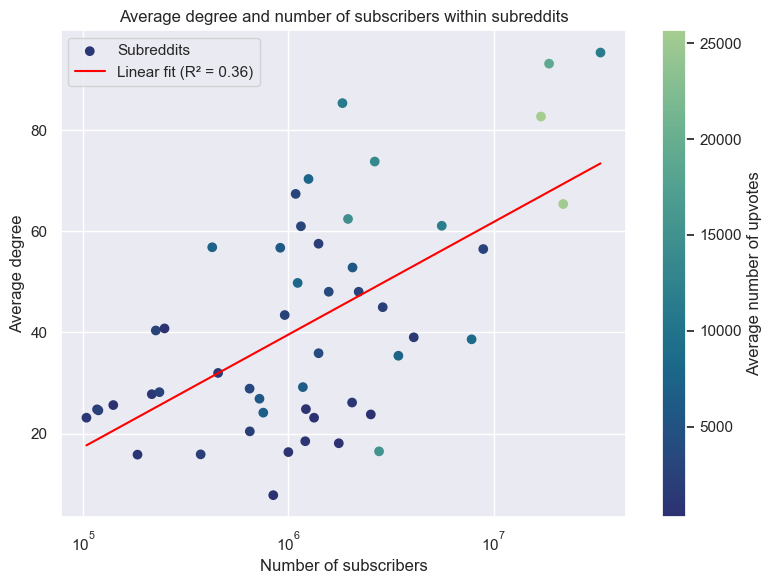

In [19]:
# For each subreddit, get the average degree, number of subscribers, and average number of upvotes
average_degree_subreddits = compute_average_degree_subreddits(G)
subscribers_subreddits = get_subscribers_subreddits(G)
upvotes_subreddits = get_upvotes_subreddits(G)

# Plot the average degree against the number of subscribers
plot_degree_subscribers(average_degree_subreddits, subscribers_subreddits, upvotes_subreddits)

From the above plot, it can be seen that there is indeed some positive correlation ($R^2 = 0.36$) between the number of subscribers and the average degree of nodes within the subreddits. Hence, the more subscribers a subreddit has, the more links the posts of that subreddit has. This supports our hypothesis that the most connected nodes predominantly belong to the largest subreddits.

Also, the color of the points (colored according to the average number of upvotes within the subreddit) indicates that the largest subreddits also have the highest average number of upvotes -- not surprisingly. 

**Network visulization**

Next we visualize the network using the kamada kawai layout. Each node is colored according to the number of upvotes, and the size of the node is proportional to the degree of the node. The network is visualized below:

In [22]:
def visualize_network(G):
    """
    Visualize the Reddit network using a Kamada-Kawai layout with node size proportional to degree, 
    and node color based on the number of upvotes.

    Args
        G: Undirected graph representing the Reddit network (nx.Graph)
    """
    # Groups and mapping for colors based on the upvotes
    scores = nx.get_node_attributes(G, 'score')
    groups = set(scores.values())
    mapping = dict(zip(sorted(groups), count()))
    nodes = G.nodes()
    colors = [mapping[G.nodes[n]['score']] for n in nodes]

    # Node size proportional to degree
    degrees = dict(G.degree())
    node_sizes = [degrees[node] * 4 for node in nodes] 

    plt.figure(figsize=(10, 10))
    nx.draw_kamada_kawai(
        G,
        node_size=node_sizes,  
        node_color=colors,     
        cmap='crest_r',       
        edge_color='lightgray',
        width=0.5,
        alpha=0.8,
        with_labels=False
    )
    plt.title("Reddit network", fontsize=20)
    plt.axis('off')
    plt.show()

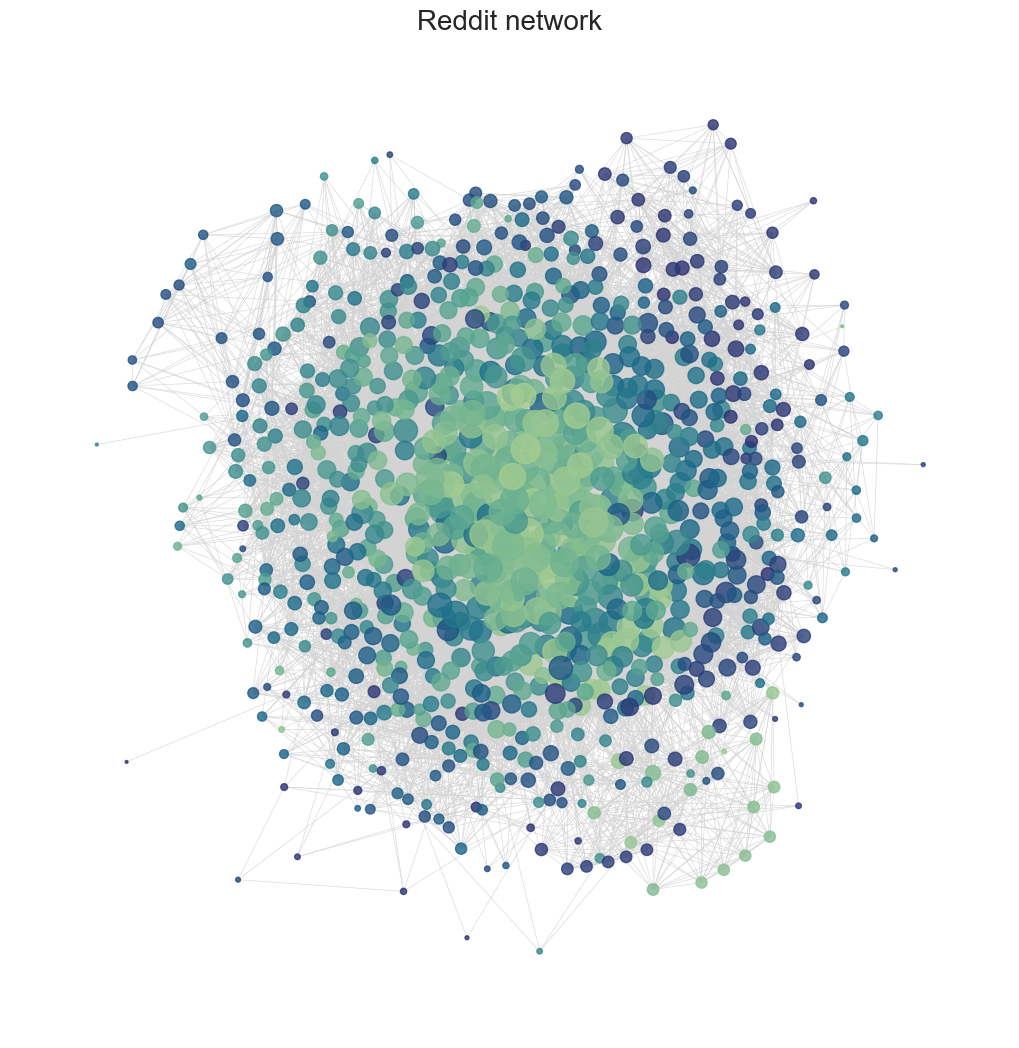

In [23]:
# Visualize the Reddit network
visualize_network(G)

**ADD DESCRIPTION OF THE NETWORK VISUALIZATION**

#### **Part 3.3: Topological and centrality measures**

Next, we compute a seleciton of topological and centrality measures of the network, in order to better understand the connections between nodes.

**Shortest paths** 

The shortest path between two nodes in the network is the smallest number of steps it takes to get from one node to another. By computing this measure for all pairs of nodes in the graph, we can determine an average shortest path and a longest shortest path (diameter) in the network. This will give us an idea of how connected the network is.

In [24]:
def find_shortest_paths(G):
    """
    Compute the shortest paths between all pairs of nodes in the graph.

    Args
        G: Undirected graph representing the Reddit network (nx.Graph)

    Returns
        shortest_path_lengths: Dictionary containing the shortest path lengths between all pairs of nodes
    """

    # Compute the shortest path lengths between all pairs of nodes
    # shortest_path_lengths[u][v] returns the shortest path length between any two pair of nodes u and v
    shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))

    return shortest_path_lengths

def compute_average(shortest_path_lengths):
    """
    Compute the average shortest path length in the network.

    Args
        shortest_path_lengths: Dictionary containing the shortest path lengths between all pairs of nodes

    Returns
        avg_shortest_path_length: Average shortest path length in the network (float)
    """

    # Compute the average shortest path length in the network
    avg_shortest_path_length = np.mean([length for source in shortest_path_lengths for target, length in 
                                        shortest_path_lengths[source].items()])

    return avg_shortest_path_length

def compute_diameter():
    """ 
    Compute the diameter of the network, and the two posts that are farthest apart.

    Returns 
        diameter: Diameter of the network (int)
        farthest_nodes: Tuple containing IDs of the two posts that are farthest apart (str)

    """

    # Find the two posts that are farthest apart (i.e. the diameter of the graph, which is the longest of the shortest-paths)
    post1, post2, diameter = max(((u, v, d) for u, distances in nx.all_pairs_shortest_path_length(G) 
                                            for v, d in distances.items()), key=lambda x: x[2])

    farthest_nodes = (post1, post2)

    return diameter, farthest_nodes

In [25]:
# Find the shortest paths between all pairs of nodes
shortest_path_lengths = find_shortest_paths(G)

# Find the average shortest path length
average_shortest_path = compute_average(shortest_path_lengths)

# Find the two posts with the longest shortest path between them (farthest apart)
diameter, farthest_nodes = compute_diameter()

# Subreddits and titles of the farthest nodes
farthest_nodes_subreddits = (G.nodes[farthest_nodes[0]]['subreddit'], G.nodes[farthest_nodes[1]]['subreddit'])
farthest_nodes_titles = (G.nodes[farthest_nodes[0]]['title'], G.nodes[farthest_nodes[1]]['title'])

In [26]:
print(f"Average shortest path length: {average_shortest_path:.2f}\n")
print(f"Longest shortest path length (diameter): {diameter}\n")
print(f"\tSubreddits of the farthest nodes: {farthest_nodes_subreddits}")
print(f"\tTitles of the farthest nodes:")
print(f"\t\t- {farthest_nodes_titles[0]}")
print(f"\t\t- {farthest_nodes_titles[1]}")

Average shortest path length: 2.43

Longest shortest path length (diameter): 5

	Subreddits of the farthest nodes: ('algotrading', 'MakeNewFriendsHere')
	Titles of the farthest nodes:
		- Backtest results for a simple "Buy the Dip" strategy
		- P L E A S E ! If you’re under age posting on this subreddit, DO NOT talk to people over 18


It is seen that the average shortest path length between a pair of nodes in the network is 2.43, meaning that on average to reach any post from any other post in the network you have to go through 2.43 other posts. This indicates that the network is quite well connected, as the average shortest path is relatively low. The longest shortest path (i.e. diameter) in the network is 5, which is between two posts from the subreddits `algotrading` and `MakeNewFriendsHere`.

**Degree centrality and closeness centrality**

Degree centrality measures the fraction of all nodes that a node is connected to. Since it's based on the number of links a node has, the nodes with the highest degree centrality are simply the most connected nodes in the network that were found in Part 3.2. The only difference is that the degree centrality is normalized.

Closeness centrality measures how easily a node can access all other nodes in the network. It's based on the average shortest path length from the node to all other nodes. This will give us an idea of which nodes are most central in the network.

While degree centrality measures the number of direct connections (i.e. "local" connectivity), closeness centrality emphasizes a node's efficiency in accessing all other nodes in the network (i.e. "global" connectivity"). We will compare the nodes with the highest degree centrality and closeness centrality to see if they are the same, or if there are nodes that are more central in the network than they are connected.

In [27]:
# Closeness centrality scores each node based on their 'closeness' to all other nodes in the network.
# The higher the closeness centrality of a node, the closer it is located to the center of the network
closeness_centrality = nx.centrality.closeness_centrality(G)
closeness_centrality = (sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True))

# Degree centrality measures the fraction of nodes a node is connected to
degree_centrality = nx.centrality.degree_centrality(G)
degree_centrality = (sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))

n = 5
top_n_nodes_closeness_centrality = closeness_centrality[:n]
top_n_nodes_degree_centrality = degree_centrality[:n]

df_top_n_nodes_closeness_centrality = pd.DataFrame({'Closeness centrality': [round(centrality, 3) for _, centrality in top_n_nodes_closeness_centrality],
                                                    'Subreddit': [G.nodes[node]['subreddit'] for node, _ in top_n_nodes_closeness_centrality],
                                                    'Title': [G.nodes[node]['title'] for node, _ in top_n_nodes_closeness_centrality]})

df_top_n_nodes_degree_centrality = pd.DataFrame({'Degree centrality': [round(centrality, 3) for _, centrality in top_n_nodes_degree_centrality],
                                                 'Subreddit': [G.nodes[node]['subreddit'] for node, _ in top_n_nodes_degree_centrality],
                                                 'Title': [G.nodes[node]['title'] for node, _ in top_n_nodes_degree_centrality]})

display_scrollable_dataframes(df_top_n_nodes_closeness_centrality, "Top 5 nodes with highest closeness centrality",
                              df_top_n_nodes_degree_centrality, "Top 5 nodes with highest degree centrality")

Closeness centrality,Subreddit,Title
0.510,HydroHomies,A doctor gave me this at work today
0.508,Showerthoughts,Funko Pops are Precious Moments figurines for Millenials
0.507,tifu,TIFU by not telling my doctor how many Tic-Tacs I eat per day
0.505,tifu,TIFU Random Flee Market Item Turns out to be Radioactive
0.505,Showerthoughts,People are vastly overestimating their capacity to hit a target with a gun
Degree centrality,Subreddit,Title
0.135,HydroHomies,A doctor gave me this at work today
0.126,tifu,TIFU by telling my roommate to drop his Japanese fetish.
0.125,Showerthoughts,Tik Tok by Kesha is going to be really weird for younger people.
0.123,brooklynninenine,least favourite cameos?


From the tables it can be seen that two of the most connected nodes in the network also have the highest degree centrality, meaning that they are not only connected to many other nodes, but also to nodes that are themselves well connected. This is not surprising, as the more connected a node is, the more likely it is to be connected to other well connected nodes. It suggests that these posts are likely part of highly active discussions or topics that draw engagement from users who also participate in other popular threads.

However, the remaining three nodes with the highest closeness centrality are not among the most connected nodes in terms of degree. These posts might represent topics or discussions that draw in diverse groups of users from otherwise disconnected areas of Reddit (at least within the subset of Reddit that this project covers).

#### **Part 3.4: Communities**

In this part we will investigate two different partitions of the graph into communities. The first partition groups posts into communities based on the subreddits, whereas the second partition does so based on the Louvain method. This is done to examine if the subreddits are reflected in the network structure (and will therefore be present in the structural communities defined by the Louvain method), or if the network structure is based on other factors.

In [28]:
def find_communities_subreddits(G):
    """
    Find the communities in the graph, i.e. groups of nodes that share the same subreddit.

    Args
        G: undirected graph of Reddit posts (nx.Graph)

    Returns
        communities: dictionary of communities, where keys are subreddits and values are 
                     nodes (posts) belonging to that subreddit (dict)
    """
    
    # Get all subreddits present in the graph
    all_subreddits = set(nx.get_node_attributes(G, 'subreddit').values())

    # Dictionary for the communities with each subreddit as key
    communities = {subreddit: [] for subreddit in all_subreddits}

    for node in G.nodes():

        # Get subreddit of the node
        subreddit = G.nodes[node]['subreddit']

        # Add the node to the corresponding community
        communities[subreddit].append(node)

    return communities

def find_communities_louvain(G):
    """
    Find the communities in the graph using the Louvain algorithm.

    Args
        G: undirected graph of Reddit posts (nx.Graph)

    Returns
        communities: dictionary of communities, where keys are genres and values are 
                     nodes characterized by that genre (dict)
    """
    # Run Louvain algorithm
    communities_louvain = nx.community.louvain_communities(G, seed = 0)

    # Dictionary for the communities with each subreddit as key
    communities = {}

    for i, community in enumerate(communities_louvain):
        
        # Add each post in the community to the dictionary
        communities[i] = list(community)
    
    return communities

def compute_modularity(G, communities):
    """
    Compute the modularity of the graph, i.e. the strength of the partition of the graph into communities.

    Args
        G: undirected graph of Reddit posts (nx.Graph)
        communities: dictionary of communities (dict)

    Returns
        modularity: modularity of the graph (float)
    """

    L = G.number_of_edges()                        # Total number of links in the graph
    n_c = len(communities)                         # Number of communities
    community_modularities = np.zeros(n_c)         # Array for storing the modularity values of each community
    
    for i, c in enumerate(communities.keys()):
        
        # Number of links in the community
        L_c = G.subgraph(communities[c]).number_of_edges()

        # Sum of the degrees of the nodes in the community
        k_c = np.sum([G.degree[node] for node in communities[c]])

        # Modularity value for the community
        community_modularities[i] = L_c / L - (k_c / (2 * L))**2

    # Modularity of the partition
    modularity = np.sum(community_modularities)

    return modularity

**Finding communities based on subreddit**

First, we create our own partition of the graph by grouping posts into communities based on the subreddits they belong to. Hence, the number of communities is equal to the number of subreddits in the network.

In [29]:
# Find communities according to subreddit
communities_subreddits = find_communities_subreddits(G)
modularity_subreddits = compute_modularity(G, communities_subreddits)

print(f'Partion of the graph based on subreddits')
print(f'\tNumber of communities: {len(communities_subreddits)} communities')
print(f'\tLargest community: {max([len(communities_subreddits[subreddit]) for subreddit in communities_subreddits])} posts')
print(f'\tSmallest community: {min([len(communities_subreddits[subreddit]) for subreddit in communities_subreddits])} posts')
print(f'\tModularity: {modularity_subreddits:.4f}')

Partion of the graph based on subreddits
	Number of communities: 50 communities
	Largest community: 20 posts
	Smallest community: 18 posts
	Modularity: 0.3201


The first partition of the network has 50 communities, each representing a subreddit. All communities consist of the same number of posts, as 20 posts were sampled from each during the data collection. The only exception is one subreddit, from which two posts were removed after the removal of isolated nodes. The modularity of the partition is 0.3201, indicating that the partition into subreddits is quite good at capturing the structure of the network.

**Finding structural communities with Louvain algorithm**

Next, we let the Louvain algorithm find the optimal partition (i.e. the partition that optimizes the modularity) of the graph into communities.

In [30]:
# Find communities according to Louvain algorithm
communities_louvain = find_communities_louvain(G)
modularity_louvain = compute_modularity(G, communities_louvain)

print(f'Partion of the graph based on Louvain algorithm')
print(f'\tNumber of communities: {len(communities_louvain)} communities')
print(f'\tLargest community: {max([len(communities_louvain[community]) for community in communities_louvain])} posts')
print(f'\tSmallest community: {min([len(communities_louvain[community]) for community in communities_louvain])} posts')
print(f'\tModularity: {modularity_louvain:.4f}')

Partion of the graph based on Louvain algorithm
	Number of communities: 17 communities
	Largest community: 181 posts
	Smallest community: 15 posts
	Modularity: 0.3745


The second partition of the network has 17 communities, and therefore much fewer communities than the partition based on subreddits. The modularity of the partition has increased to 0.3745, indicating that the Louvain method is slightly better at capturing the structure of the network.

In [31]:
def plot_communities(G, communities_subreddits, communities_louvain, seed_subreddits=1, seed_louvain=0, layout_seed=12):
    """
    Plot the communities based on subreddits and Louvain algorithm.

    Args:
        G: NetworkX graph
        communities_subreddits: Dictionary of communities for subreddits
        communities_louvain: Dictionary of communities for Louvain
    """

    # Set the seed for reproducibility
    random.seed(seed_subreddits)

    # Initialize colors dictionary for communities_subreddits
    colors_subreddits = {}

    for com in communities_subreddits.keys():
        color = random.randint(0, 0xFFFFFF)  # creates random RGB color
        for node in communities_subreddits[com]:  # fill colors dictionary with the particular color for the community nodes
            colors_subreddits[node] = color

    # Create a list of colors for the nodes in the graph
    node_colors_subreddits = [colors_subreddits[node] for node in G.nodes()]

    # Set the seed for reproducibility
    random.seed(seed_louvain)

    # Initialize colors dictionary for communities_louvain
    colors_louvain = {}

    for com in communities_louvain.keys():
        color = random.randint(0, 0xFFFFFF)  # creates random RGB color
        for node in communities_louvain[com]:  # fill colors dictionary with the particular color for the community nodes
            colors_louvain[node] = color

    # Create a list of colors for the nodes in the graph
    node_colors_louvain = [colors_louvain[node] for node in G.nodes()]

    # Generate positions for the nodes
    pos = nx.spring_layout(G, iterations=15, seed=layout_seed)

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    # Plot the first graph (communities_subreddits)
    sns.set_style("ticks")
    nx.draw_networkx_nodes(G, pos=pos, node_size=10, node_color=node_colors_subreddits, cmap=plt.cm.viridis, ax=axes[0])
    nx.draw_networkx_edges(G, pos=pos, alpha=0.1, ax=axes[0])
    axes[0].set_title('Communities based on subreddits')
    axes[0].axis('off')

    # Plot the second graph (communities_louvain)
    nx.draw_networkx_nodes(G, pos=pos, node_size=10, node_color=node_colors_louvain, cmap=plt.cm.viridis, ax=axes[1])
    nx.draw_networkx_edges(G, pos=pos, alpha=0.1, ax=axes[1])
    axes[1].set_title('Communities based on Louvain algorithm')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

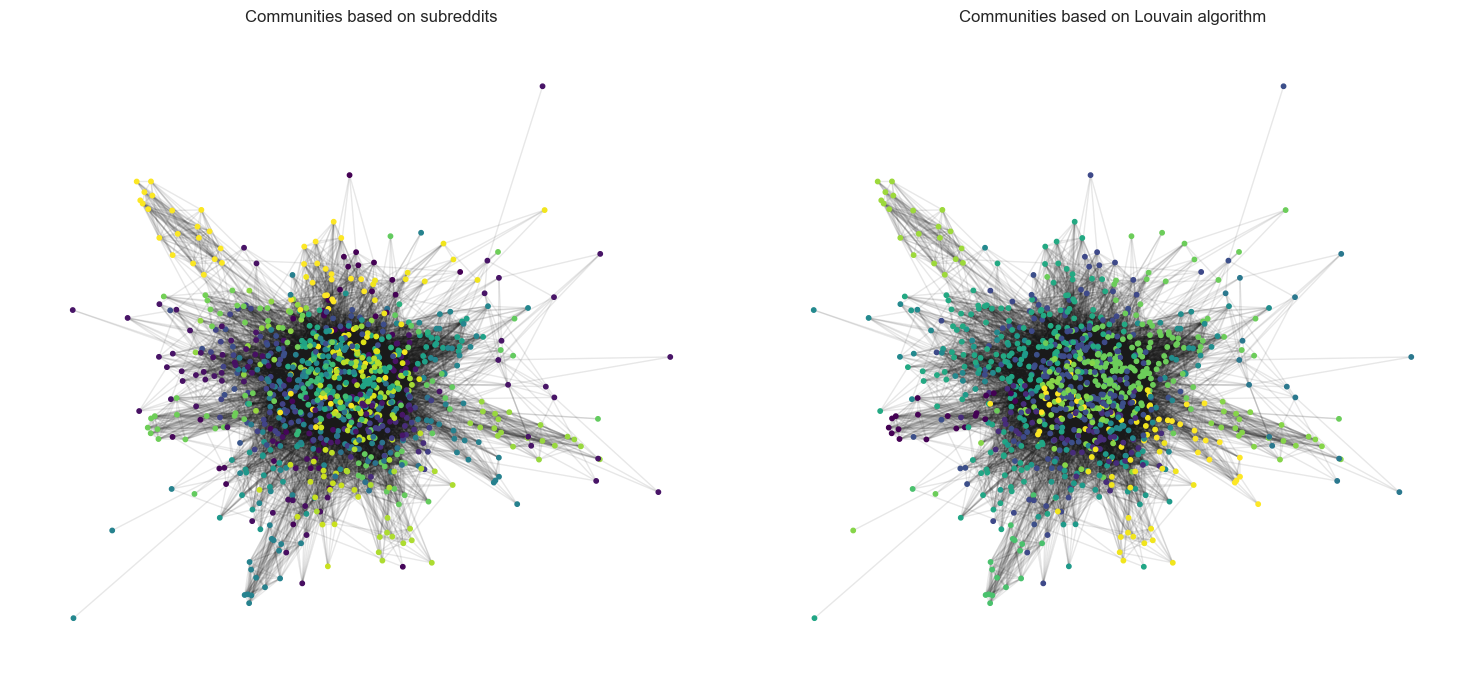

In [32]:
# Plot both partitions side-by-side
plot_communities(G, communities_subreddits, communities_louvain)

## **Part 4: Analyzing sentiment patterns**

Reddit is a platform where users share everything from thoughts to random memes. This makes it an interesting platform to analyze the sentiment of the different communities. One way of doing this us by a sentiment analysis. Sentiment analysis is a value that describes the emotional tone of a text.\
It probably doesnt comes as a surprice for anyone that text can show emotions. In different scenarios, people will express different emotions. For example, a post in a subreddit about funny cat videos will probably have a positive sentiment, while a post in a subreddit about criticizing Taylor Swift will probably have a negative sentiment.\
In this analysis we will use the [Afinn wordlist](http://www2.imm.dtu.dk/pubdb/edoc/imm6006.pdf) to analyze the sentiment. Afinn will be described in more detail in the next section.

#### **Part 4.1: Sentiment analysis**

For the project the **Afinn** lexicon will be used.\
**Afinn** is a wordlist where each word is scored between **-5** (very negative) and **5** (very positive). This design, allows for positive and negative words to cancel each other out, potentially resulting in a neutral score of **0**. This also means that the sentiment score of a text is calculated as the sum of these scores. Due to the lack of any type of normalization, longer texts can end up with extreme sentiment scores, whether positive or negative.

##### What is the Afinn Wordlist?  

The [Afinn wordlist](http://www2.imm.dtu.dk/pubdb/edoc/imm6006.pdf) was developed by **DTU’s own Finn Årup Nielsen** to analyze sentiment in short-form content like microblogs—platforms such as **Twitter (X)** and **Reddit**. It was first introduced in **2009** and has been updated since.  

Difference from other wordlists:  

- **Inclusion of modern slang**: Words like *“WTF”* and *“LOL”* are part of the list.  
- **Scoring System**: Most words are scored at **-2** or **2**, with extreme scores of **-5** or **5** reserved for particularly strong sentiment.  
- **Coverage of obscene words**<!--: Making it particularly effective for analyzing casual or informal text. --> 

##### How it Works  

The sentiment score of a text is calculated as the **sum of the scores of its words**. For example:  

- A highly positive text with words like *"amazing" (3)* and *"love" (3)* scores **6**.  
- A mixed text with *"hate" (-3)* and *"beautiful" (2)* scores **-1**.  

Since there’s **no normalization**, longer texts often result in higher or lower sentiment scores, depending on word usage.  

> *Keep in mind*: The Afinn wordlist paper was published in **2011**, meaning while the list has been updated, slang usage may have evolved since then.


In [33]:
def load_wordlist():
    """
    Load the LabMT wordlist.

    Returns
        wordlist: wordlist with happiness scores (pd.DataFrame)
        happiness_score_dict: dictionary of words in the wordlist and their happiness scores (dict)
    """
    wordlist = pd.read_table("../Assignment 2/wordlist.txt")
    happiness_score_dict = wordlist.set_index('word')['happiness_average'].to_dict()

    return wordlist, happiness_score_dict

# Load the LabMT wordlist
wordlist, happiness_score_dict = load_wordlist()


def tokenize_text(text):
    """
    Tokenize a text into words using NLTK's word_tokenize function.

    Args:
        text: clean text to be tokenized (str)

    Returns:
        tokens: tokenized text (list)
    """

    # Tokenize the text
    tokens = nltk.tokenize.word_tokenize(text)

    # Remove punctuation tokens
    tokens = [token for token in tokens if token.isalnum()]

    # Set tokens to lowercase
    tokens = [token.lower() for token in tokens]

    # Lemmatize tokens using NLTK's WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens

def compute_sentiment(tokens, happiness_score_dict):
    """ 
    Compute the sentiment of a tokenized text based on the LabMT wordlist.

    Args:
        tokens: tokenized text (list)
        happiness_score_dict: dictionary of words in the wordlist and their happiness scores (dict)

    Returns:
        sentiment: average sentiment score for the tokens (float)
        words_found: number of words from the wordlist found in the text (int)
    """

    happiness_scores = []   # List to store the happiness scores of the tokens

    for token in tokens:

        # Check if the token is in the wordlist
        if token in happiness_score_dict:

            # Add the happiness score to the list, and increment the number of words found
            happiness_scores.append(happiness_score_dict[token])

    # Compute the sentiment score
    if len(happiness_scores) > 0:
        sentiment = np.mean(happiness_scores)

    else:
        sentiment = 0

    return sentiment

def add_sentiment_attributes(G, happiness_score_dict, analyzer = 'afinn'):
    """
    Add two sentiment attributes (sentiment_text and sentiment_comments) to the nodes in the graph, 
    based on the sentiment of the text (plus title) and comments of the nodes.

    Args 
        G: undirected graph of Reddit posts (nx.Graph)
        happiness_score_dict: dictionary of words in the wordlist and their happiness scores (dict)

    Returns
        G: undirected graph of Reddit posts with sentiment attributes (nx.Graph)
    """

    for node in tqdm(list(G.nodes())):
        
        # Get the title, text and comments of the node 
        text = G.nodes[node]['text']
        title = G.nodes[node]['title']
        comments = [comment['body'] for comment in G.nodes[node]['comments']][:50]

        if analyzer == 'labmt':
            # Convert to tokens
            tokens_text = tokenize_text(text)
            tokens_title = tokenize_text(title)
            tokens_comments = [tokenize_text(comment) for comment in comments]

            # Compute the sentiment of the text and comments
            sentiment_score_text = compute_sentiment(tokens_text, happiness_score_dict)
            sentiment_score_title = compute_sentiment(tokens_title, happiness_score_dict)
            sentiment_score_comments = [compute_sentiment(tokens, happiness_score_dict) for tokens in tokens_comments]

        elif analyzer == 'afinn':
            
            # Instantiate the AFINN sentiment analyzer
            afinn = Afinn(language='en')

            # Compute the sentiment of the text and comments
            sentiment_score_text = afinn.score(text)
            sentiment_score_title = afinn.score(title)
            sentiment_score_comments = [afinn.score(comment) for comment in comments]
        
        # Average over the sentiment scores of the comments
        sentiment_score_comments = np.mean(sentiment_score_comments)

        # Average the sentiment scores of the text and title
        sentiment_score_text = (sentiment_score_text + sentiment_score_title) / 2

        # Add sentiment scores as node attributes to the node
        G.nodes[node]['sentiment_text'] = sentiment_score_text
        G.nodes[node]['sentiment_comments'] = sentiment_score_comments

    return G

In [34]:
# Add sentiment scores to the nodes in the Reddit graph
G = add_sentiment_attributes(G, happiness_score_dict, analyzer = 'afinn')

100%|██████████| 998/998 [00:28<00:00, 35.42it/s]


For each community, calculate the average sentiment of the posts and comments.

In [35]:
def compute_sentiment_subreddits_statistics(communities_subreddits, G):
    """
    Calculate average sentiment, standard deviation, and standard error of the mean
    of posts and comments for each subreddit.

    Args:
        communities_subreddits: Dictionary where keys are subreddit names and values are lists of node IDs (dict)
        G: undirected graph of Reddit posts with sentiment attributes (nx.Graph)

    Returns:
        sentiment_subreddits_statistics: Dictionary where each subreddit is a key, and its value is a dictionary containing:
              'text_avg', 'text_std', 'text_sem', 'comments_avg', 'comments_std', 'comments_sem' (dict).
    """
    sentiment_subreddits_statistics = {}
    
    for subreddit, nodes in communities_subreddits.items():
        # Extract sentiments for the current subreddit
        sentiment_texts = [G.nodes[node]['sentiment_text'] for node in nodes]
        sentiment_comments = [G.nodes[node]['sentiment_comments'] for node in nodes]
        
        # Calculate averages and standard deviations
        sentiment_text_avg = np.mean(sentiment_texts)
        sentiment_text_std = np.std(sentiment_texts)
        sentiment_text_sem = np.std(sentiment_texts) / np.sqrt(len(sentiment_texts))

        sentiment_comments_avg = np.mean(sentiment_comments)
        sentiment_comments_std = np.std(sentiment_comments)
        sentiment_comments_sem = np.std(sentiment_comments) / np.sqrt(len(sentiment_comments))
        
        # Store the results in a dictionary under the subreddit key
        sentiment_subreddits_statistics[subreddit] = {
            "text_avg": sentiment_text_avg,
            "text_std": sentiment_text_std,
            "text_sem": sentiment_text_sem,
            "comments_avg": sentiment_comments_avg,
            "comments_std": sentiment_comments_std,
            "comments_sem": sentiment_comments_sem
        }
    
    return sentiment_subreddits_statistics

def plot_sentiment_subreddits_statistics(sentiment_subreddits_statistics):
    """
    Plot two subplots comparing for each subreddit:
    1) The average sentiment of the text with error bars representing the standard error of the mean
    2) The average sentiment of the text and comments

    Args:
        sentiment_subreddits_statistics: Dictionary where each subreddit is a key, and its value is a dictionary containing:
              'text_avg', 'text_std', 'text_sem', 'comments_avg', 'comments_std', 'comments_sem' (dict).
    """

    sns.set_style('darkgrid')
    sns.set(font_scale=1.)

    # Create a dataframe from the sentiment statistics
    df = pd.DataFrame(sentiment_subreddits_statistics).T
    df = df.reset_index().rename(columns={'index': 'subreddit'})

    x_values = np.arange(len(df['subreddit']))

    # Plot the average sentiment of the text
    fig, axs = plt.subplots(2, 1, figsize=(13, 9), sharex=True)

    # Define a colormap that transitions from red to green
    # cmap = plt.get_cmap('RdYlGn')
    cmap = LinearSegmentedColormap.from_list('custom_red_green', ['red', 'yellow', 'green'], N=256)
    # cmap = plt.get_cmap('RdYlGn')

    positive_values = df['text_avg'][df['text_avg'] >= 0]
    negative_values = df['text_avg'][df['text_avg'] < 0]

    scaler_pos = MinMaxScaler(feature_range=(0, 1))
    scaler_neg = MinMaxScaler(feature_range=(-1, 0))

    df.loc[df['text_avg'] >= 0, 'text_avg_normalized'] = scaler_pos.fit_transform(positive_values.values.reshape(-1, 1)).flatten()
    df.loc[df['text_avg'] < 0, 'text_avg_normalized'] = scaler_neg.fit_transform(negative_values.values.reshape(-1, 1)).flatten()

    norm = plt.Normalize(-1, 1)
    colors = [cmap(norm(val)) for val in df['text_avg_normalized']]

    # Plot the average sentiment of the text on the first subplot
    error_kw = {'ecolor': 'grey', 'capsize': 5, 'elinewidth': 2, 'label': 'Standard error of the mean'}
    axs[0].bar(df['subreddit'], df['text_avg'], yerr=df['text_sem'],color=colors, error_kw=error_kw) # With error bars
    # axs[0].bar(df['subreddit'], df['text_avg'], color=colors) # No error bars
    axs[0].set_xlim(x_values.min()-1, x_values.max()+1)
    axs[0].set_ylabel('Average sentiment score of post text')
    axs[0].legend()

    # Plot the average sentiment of the text on the second subplot
    # Separate positive and negative values for text_avg and comments_avg
    text_avg_pos = df['text_avg'].clip(lower=0)
    text_avg_neg = df['text_avg'].clip(upper=0)
    comments_avg_pos = df['comments_avg'].clip(lower=0)
    comments_avg_neg = df['comments_avg'].clip(upper=0)

    axs[1].bar(df['subreddit'], text_avg_pos, color='#2a4e81', label='Post')
    axs[1].bar(df['subreddit'], comments_avg_pos, bottom=text_avg_pos, color='darkorchid', label='Comments')
    axs[1].bar(df['subreddit'], text_avg_neg, color='#2a4e81')
    axs[1].bar(df['subreddit'], comments_avg_neg, bottom=text_avg_neg, color='darkorchid')

    axs[1].set_xlim(x_values.min()-1, x_values.max()+1)
    axs[1].set_ylabel('Average sentiment score')
    axs[1].set_xticks(ticks=x_values)
    axs[1].set_xticklabels(df['subreddit'], rotation=90)
    axs[1].legend()

    plt.suptitle('Average sentiment scores of post text and comments for each subreddit')
    plt.tight_layout()
    plt.show()

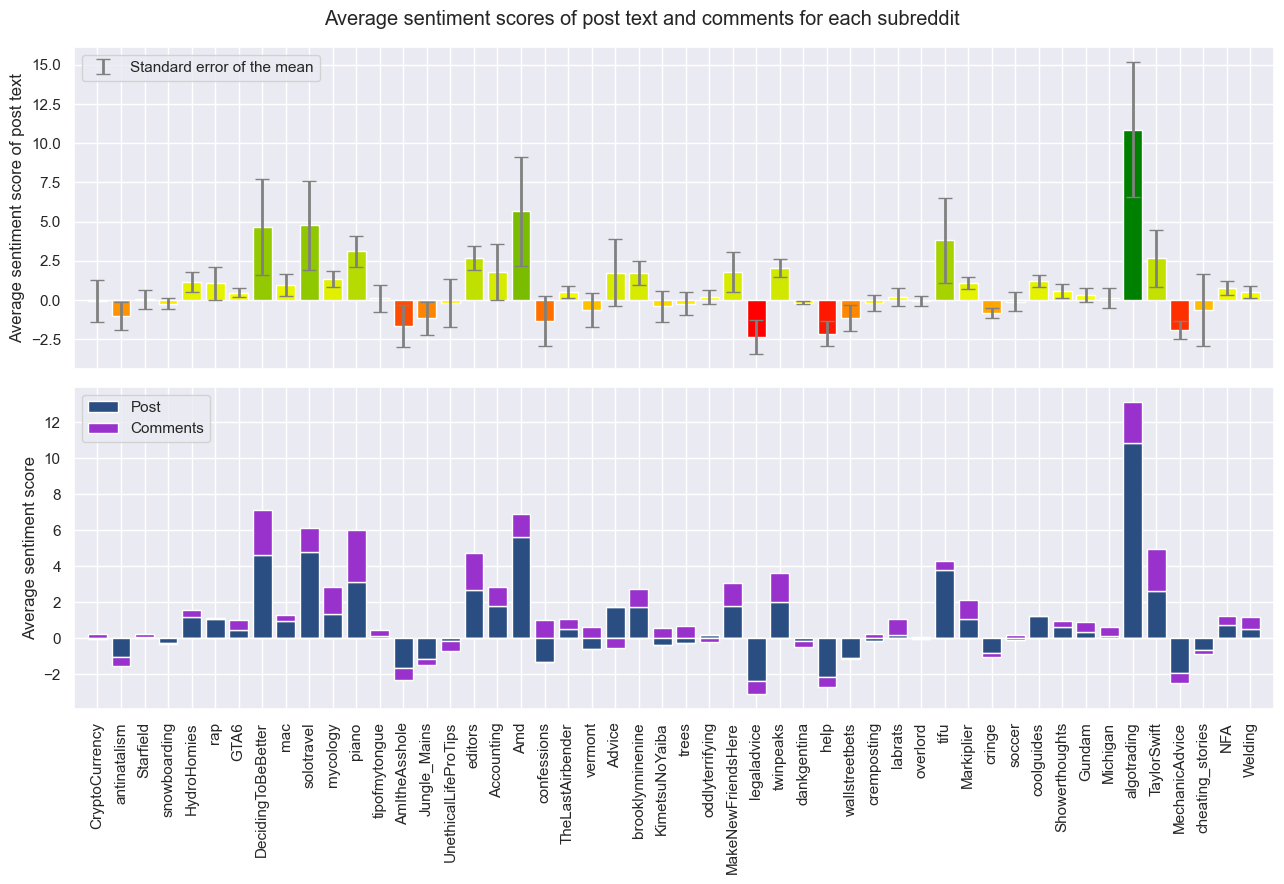

In [36]:
# Sentiment statistics for all subreddits
sentiment_subreddits_statistics = compute_sentiment_subreddits_statistics(communities_subreddits, G)

plot_sentiment_subreddits_statistics(sentiment_subreddits_statistics)

In the figure above, the **average sentiment** of the posts and comments in each community is shown.  

For many communities, the sentiment scores revolve around **0**, even when considering the **standard error**. Examples of such subreddits include `overlord` and `cremposting`. This suggests that for these subreddits, there is **no clear sentiment pattern**.  

##### Highlights  

- **Top 3 Subreddits with the Most Positive Sentiment**:  
  - `algotrading`  
  - `Amd`  
  - `solotravel` / `DecidingToBeBetter`  

  The positivity in `algotrading` might stem from its focus on algorithmic trading, where users are often **optimistic** and **excited** about their strategies.  

- **Top 3 Subreddits with the Most Negative Sentiment**:  
  - `legaladvice`  
  - `help`  
  - `MechanicAdvice`  

  These subreddits share a common theme: they involve **asking for advice**. This could indicate that people are more likely to seek advice when they are in a **negative mood** or facing significant challenges.  


##### Post vs. Comment Sentiment  

The second figure above explores the **average sentiment** of posts and comments in each subreddit.  

One interesting observation is that some subreddits exhibit **opposing sentiments** between posts and comments:  

- **Examples of Positive Comment Sentiment and Negative Post Sentiment**:  
  - `trees`  
  - `vermont`  
  - `KimetsuNoYaiba`  
  - `confessions`  

Interestingly, there are **no examples** where comments have **negative sentiment** while posts exhibit **positive sentiment**.  



Next we will look at the sentiment for posts and comments individually for a selected subreddit.

In [37]:
def compute_sentiment_selected_subreddit_statistics(communities_subreddits, G, subreddit):
    """
    Compute sentiment statistics for a selected subreddit.

    Args:
        communities_subreddits: Dictionary where keys are subreddit names and values are lists of node IDs (dict)
        G: undirected graph of Reddit posts with sentiment attributes (nx.Graph)
        subreddit: The subreddit to compute statistics for (str)

    Returns:
        df: DataFrame containing sentiment statistics for the selected subreddit
    """
    sentiment_selected_subreddit_statistics = {"sentiment_text_per_post": [],  
                                               "sentiment_comments_per_post": []}
    
    for node in communities_subreddits[subreddit]:

        # Extract sentiments for every post
        sentiment_texts = G.nodes[node]['sentiment_text']
        sentiment_comments = G.nodes[node]['sentiment_comments']

        # Append to the dictionary
        sentiment_selected_subreddit_statistics["sentiment_text_per_post"].append(sentiment_texts)
        sentiment_selected_subreddit_statistics["sentiment_comments_per_post"].append(sentiment_comments)

    # Create a dataframe from the sentiment statistics
    df = pd.DataFrame(sentiment_selected_subreddit_statistics)
    df = df.reset_index().rename(columns={'index': 'post'})

    return df

def plot_sentiment_selected_subreddit_statistics(df, subreddit):
    """
    Plot sentiment statistics for a selected subreddit.

    Args:
        df: DataFrame containing sentiment statistics for the selected subreddit
        communities_subreddits: Dictionary where keys are subreddit names and values are lists of node IDs (dict)
        G: undirected graph of Reddit posts with sentiment attributes (nx.Graph)
        subreddit: The subreddit to plot statistics for (str)
    """

    x_values = np.arange(len(df))

    # Plot the sentiment across posts within the selected subreddit
    text_pos = df['sentiment_text_per_post'].clip(lower=0)
    text_neg = df['sentiment_text_per_post'].clip(upper=0)
    comments_pos = df['sentiment_comments_per_post'].clip(lower=0)
    comments_neg = df['sentiment_comments_per_post'].clip(upper=0)

    plt.bar(x_values, text_pos, color='#2a4e81', label='Post')
    plt.bar(x_values, comments_pos, bottom=text_pos, color='darkorchid', label='Comments')
    plt.bar(x_values, text_neg, color='#2a4e81')
    plt.bar(x_values, comments_neg, bottom=text_neg, color='darkorchid')

    plt.xlim(x_values.min()-1, x_values.max()+1)
    plt.ylabel('Average sentiment score')
    plt.xticks(ticks=x_values, labels=df['post'], rotation=90)
    plt.title(f'Average scores for subreddit: {subreddit}')
    plt.legend()
    plt.show()

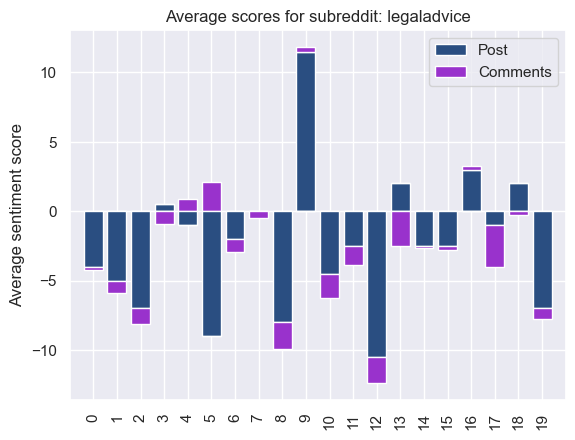

In [38]:
# Compute sentiment statistics for the selected subreddit
# subreddit = 'UnethicalLifeProTips'
# subreddit = 'cheating_stories'
subreddit = 'legaladvice'
df_subreddits = compute_sentiment_selected_subreddit_statistics(communities_subreddits, G, subreddit)

# Print the ID of the most negative and most positive posts
most_negative_post_index = int(df_subreddits.loc[df_subreddits['sentiment_text_per_post'].idxmin()]['post'])
most_positive_post_index = int(df_subreddits.loc[df_subreddits['sentiment_text_per_post'].idxmax()]['post'])
most_negative_post = communities_subreddits[subreddit][most_negative_post_index]
most_positive_post = communities_subreddits[subreddit][most_positive_post_index]

# print(f"Mosnegative post: {most_negative_post}, Title: {G.nodes[most_negative_post]['title']}")
# print(f"Most positive post: {most_positive_post}, Title: {G.nodes[most_positive_post]['title']}")

# Plot sentiment statistics for the selected subreddit
plot_sentiment_selected_subreddit_statistics(df_subreddits, subreddit)

For the `legaladvice` subreddit the average sentiment was negative. Looking at the sentiment for the post and comments individually, its seen that for the majority of posts the sentiment does have a negative sentiment. Only a small handful of the posts have a positive sentiment. Im most cases the sentiment of the comments and posts are fairly similar. 4 of the posts have different sentiment for the comments and posts.
  
---

**Comparing Communities: Subreddits vs. Louvain Algorithm**

Currently, we have only looked at the sentiment of the communities based on the subreddits directly. But remember that we also found communities based on the **Louvain algorithm**. Now the sentiment of these communities will be analyzed. 

**Examining Louvain Communities**

First, we will quickly examine the new communities found by the Louvain algorithm. To do so, we explore the structural communities by analyzing the distribution of posts across these communities. 

We achieve this by plotting a **confusion matrix** with:

- **Subreddits** on one axis
- **Louvain communities** on the other axis

This visualization will give us an idea of how the subreddits are reflected in the structural communities.


In [39]:
def create_confusion_matrix(communities_louvain_common, communities_subreddits):
    """
    Create a confusion matrix between the communities found by the Louvain algorithm and the communities based on subreddits.

    Args
        communities_louvain_common: dictionary of communities found by Louvain algorithm (dict)
        communities_subreddits: dictionary of communities based on subreddits (dict)

    Returns
        confusion_matrix: confusion matrix between the communities (np.array)
    """

    # Initalize confusion matrix
    # confusion_matrix = np.zeros((len(communities_louvain_common), len(communities_subreddits)))
    confusion_matrix = np.zeros((len(communities_subreddits), len(communities_louvain_common)))


    for i, subreddit_louvain in enumerate(communities_louvain_common): 
        for j, subreddit_all in enumerate(communities_subreddits):

            # Find the intersection between the two communities
            intersection = set(communities_louvain_common[subreddit_louvain]) & set(communities_subreddits[subreddit_all])
            confusion_matrix[j, i] = len(intersection)

    return confusion_matrix

def normalize_confusion_matrix(D):
    """
    Normalize the confusion matrix to have values between 0 and 1.

    Args:
        D: confusion matrix (np.array)
        
    Returns:
        Normalized confusion matrix
    """
    return (D - D.min()) / (D.max() - D.min())

def plot_confusion_matrix(D, communities_louvain_common, communities_subreddit_all_common):
    """
    Plot the confusion matrix between the communities found by the Louvain algorithm and the communities based on subreddits.

    Args
        D: confusion matrix between the communities (np.array)
        communities_louvain_common: list of communities found by Louvain algorithm (list)
        communities_subreddit_all_common: list of communities based on subreddits (list)
        
    """

    D = normalize_confusion_matrix(D)
    
    fig, ax = plt.subplots(figsize=(5, 12))
    
    sns.heatmap(D, annot=False, fmt='g', cmap='crest_r',
                xticklabels=communities_louvain_common, 
                yticklabels=communities_subreddit_all_common, linecolor='white', linewidths=0.01)
    
    plt.xlabel('Communities (Louvain algorithm)')
    plt.ylabel('Communities (all subreddits)')
    plt.title('Confusion matrix between communities')
    
    plt.show()

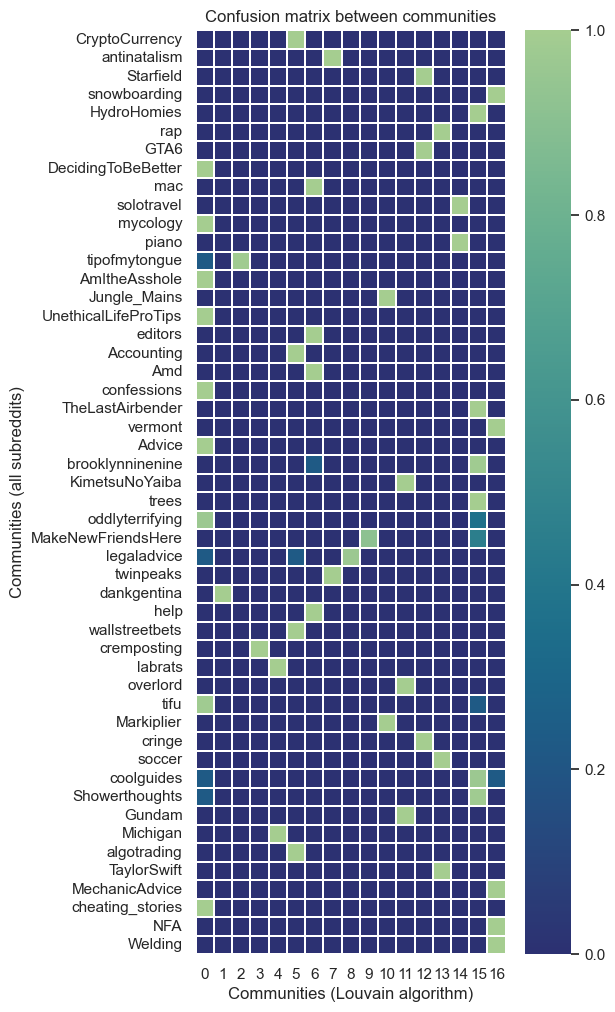

In [40]:
D = create_confusion_matrix(communities_louvain, communities_subreddits)
D = np.log((D+1)/20) #Make small values more visible

plot_confusion_matrix(D, list(communities_louvain.keys()), list(communities_subreddits.keys()))

The confusion matrix shows that most posts from the same subreddit are grouped together in the same community, indicating that the subreddits do have a substantial impact on the network structure. Looking into which subreddits are grouped together, we see that subreddits with similar themes or topics often fall into the same community. This happens even though the Louvain algorithm groups posts only based on how they are connected in the network, without knowing anything about their themes or topics. 

For example, the subreddits `wallstreetbets`, `algotrading`, `Accounting`, and `CryptoCurrency`, are all grouped together in community ID 5. These subreddits are all related to finance and investing, and therefore likely have some overlap in their user base and content, leading to cross-commenting between them. 

Similarly, the subreddits `tifu`, `Advice`, `UnethicalLifeProTips`, `AmITheAsshole`, `confessions`, `DecidingToBeBetter`, and `cheating_stories` are also grouped together in community ID 0. These subreddits are all related to personal stories and advice, meaning that posts and users will likely be well-connected between these subreddits as well. However, this community also consists of the subreddits `oddlyterrifying` and `mycology`, which are subreddits for sharing oddly terrifying (duh) pictures and videoes, and discussing mushrooms, respectively. These two subreddits do not seem to fit into the theme of the other subreddits in the community, indicating that the network structure is not solely based on the subreddits, but also on other factors -- such as shared commenters who participate in diverse topics. Apparently, some Reddit users who enjoy sharing personal stories and advice also have a surprising fascination with terrifying pictures and mushrooms?

**Size of the Louvain communities**

With Louvain the nodes have been grouped together into 17 communities. The largest communities contain well over 100 nodes and the smallest below 20 nodes.

In [90]:
def get_n_most_common_communities(community_dict, n=1):
    """
    Get the n most common communities in the community dictionary
    
    Args
        community_dict: dictionary of communities (dict)
        n: number of most common communities to return (int)
        
    Returns
        most_common_communities: list of the n most common communities (list)
        community_to_artists: dictionary of genres to artists (dict)
    """

    # Get the counts of each genre in the community dictionary
    genre_counts = {genre: len(community_dict[genre]) for genre in community_dict}
    most_common_communities = sorted(genre_counts, key=genre_counts.get, reverse=True)[:n]
    
    # Dictionary of genres to artists
    community_to_artists = {genre: community_dict[genre] for genre in most_common_communities}
    
    
    return community_to_artists

def display_most_common_communities(communities_dict, header="Most Common Communities", max_height=500):
    """
    Display a dictionary of communities and their post counts as a scrollable HTML table.

    Args:
        communities_dict (dict): Dictionary where keys are community names and values are lists of posts.
        header (str): Header for the HTML table.
        max_height (int): Maximum height of the scrollable table in pixels.
    """
    # Convert the dictionary into a DataFrame
    data = {
        "Community": list(communities_dict.keys()),
        "Number of Posts": [len(posts) for posts in communities_dict.values()]
    }
    df = pd.DataFrame(data)

    # Generate the scrollable HTML table
    display(HTML(f"""
    <style>
        .dataframe th, .dataframe td {{
            text-align: left;
        }}
    </style>
    <div style="max-height: {max_height}px; overflow-y: auto; padding: 5px; width: 100%;">
        <h3>{header}</h3>
        {df.to_html(index=False)}
    </div>
    """))

In [91]:
most_common_communities_louvain = get_n_most_common_communities(communities_louvain, n=17)
display_most_common_communities(most_common_communities_louvain, "Louvain communities")


Community,Number of Posts
0,181
15,122
16,101
5,81
6,81
11,60
12,60
13,60
4,40
7,40


**Sentiment Louvain communities**

In [88]:
def compute_sentiment_selected_louvain_statistics(communities_louvain, G, community_ID):
    """
    Compute sentiment statistics for a selected Louvain community.

    Args:
        communities_louvain: Dictionary where keys are Louvain communtiy IDs and values are lists of node IDs (dict)
        G: undirected graph of Reddit posts with sentiment attributes (nx.Graph)
        community_ID: The ID of the Louvain community to compute statistics for (int)

    Returns:
        df: DataFrame containing sentiment statistics for the selected Louvain community
    """
    sentiment_selected_louvain_statistics = {"sentiment_text_per_post": []}
    
    for node in communities_louvain[community_ID]:
        # Extract sentiments for every post
        sentiment_texts = G.nodes[node]['sentiment_text']
        
        # Compute the average sentiment score for the post
        avg_sentiment = np.mean(sentiment_texts)
        
        # Append to the dictionary
        sentiment_selected_louvain_statistics["sentiment_text_per_post"].append(avg_sentiment)

    # Create a dataframe from the sentiment statistics
    df = pd.DataFrame(sentiment_selected_louvain_statistics)
    df = df.reset_index().rename(columns={'index': 'post'})
    
    return df

def plot_sentiment_louvain_heatmap(communities_louvain, G):
    """
    Plot sentiment heatmap for all Louvain communities.

    Args:
        communities_louvain: Dictionary where keys are Louvain communtiy IDs and values are lists of node IDs (dict)
        G: undirected graph of Reddit posts with sentiment attributes (nx.Graph)
    """
    # Dataframe for all Louvain communities
    sentiment_louvain_statistics = pd.DataFrame()

    # Linspace
    inner_edges = np.linspace(-5, 5, 10)
    bin_edges = [-np.inf] + inner_edges.tolist() + [np.inf]

    # Loop over all Louvain communities
    for community in communities_louvain:
        
        # Compute sentiment statistics for the selected Louvain community
        df = compute_sentiment_selected_louvain_statistics(communities_louvain, G, community)
        
        # Sentiment across posts within the selected Louvain community
        text_scores = df['sentiment_text_per_post']
        
        # Bin the sentiment scores
        sentiment_bins = pd.cut(text_scores, bins=bin_edges)

        # Normalize according to the number of posts
        sentiment_bin_counts = sentiment_bins.value_counts(normalize=True)
        
        # Add the sentiment bins to the dataframe for that community
        community_df = pd.DataFrame({'community': community, 'sentiment_bin': sentiment_bin_counts.index, 'frequency': sentiment_bin_counts.values})
        sentiment_louvain_statistics = pd.concat([sentiment_louvain_statistics, community_df], ignore_index=True)

    # Create a heatmap data
    heatmap_data = sentiment_louvain_statistics.pivot(index='sentiment_bin', columns='community', values='frequency').fillna(0)

    # Switch axes and reverse the order of the bins
    heatmap_data = heatmap_data.iloc[::-1] # positive sentiment at the top

    # Plot the heatmap
    plt.figure(figsize = (12, 5))
    sns.heatmap(heatmap_data, cmap='crest_r', annot=False, cbar=True)
    plt.xlabel('Louvain community')
    plt.ylabel('Sentiment bin')
    plt.title('Heatmap of sentiment distribution across Louvain communities')
    plt.show()

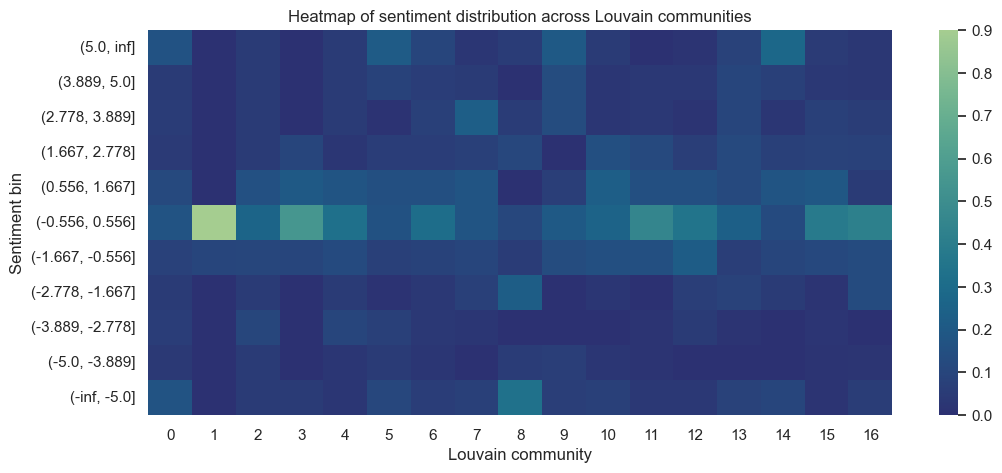

In [89]:
# Plot sentiment statistics for the selected subreddit
plot_sentiment_louvain_heatmap(communities_louvain, G)

The sentiment of the louvain communities is illustrated in the figure above. Let us explain the figure.\
Each column represents a community, each row represents a bin for the sentiment score. The color of the cell represents the fraction of posts in the community that have a sentiment score within the bin.\
The sentiment scores are divided into 11 bins, where the middle bin includes the sentiment score of 0 (indicating no words from the Afinn wordlist were found in the text). 

| Bin Interval | Bin Interval |
|--------------------------|--------------------------|
| (5.0, ∞]                | (-0.5, 0.5]             |
| (3.8, 5.0]              | (-1.6, -0.5]            |
| (2.7, 3.8]              | (-2.7, -1.6]            |
| (1.6, 2.7]              | (-3.8, -2.7]            |
| (0.5, 1.6]              | (-5.0, -3.8]            |
|                          | (-∞, -5.0]             |

So, what can we learn from the figure?\
For some communities, the sentiment scores are concentrated in the bin around 0, indicating that the sentiment of the posts in these communities is neutral.\
For the largest community (0) the sentiment scores are all over the place, indicating that the sentiment of the posts in this community is not consistent. This perhaps does make sense, as this community consists of a mix of subreddits with different themes.\
There is no clear cut "only positive" or "only negative" sentiment in any of the communities. This indicates that while sentiment analysis gives an indication of the sentiment of the posts, it is not that telling about the what the communities consist of.

#### **Part 4.2: Wordclouds**

##### Understanding Louvain Communities

Imagine we are only provided with **Louvain communities** and no subreddit information. How could we then understand the content of these communities?\
One idea is to create **word clouds** and interpret the communities based on the words displayed.  

**Term Frequency (TF)**

In this analysis, the **Term Frequency (TF)** is defined as:  

$TF = \log(\text{count} + 1)$

This approach ensures we never take the logarithm of 0. Alternatively, TF could have been defined simply as the raw **number of times a word appears**.  

**Inverse Document Frequency (IDF)**

The **Inverse Document Frequency (IDF)** is defined as:  
1. Count the total number of documents \(N\) in the directory.
2. For each term, calculate how many documents it appears in.
3. Calculate the IDF as follows: IDF(term) = $\log\left(\frac{N}{\text{count}} + 1\right)$


Step by step, the **word clouds** are created by the following process:
1. Define communities
2. Stack all posts and comments in each community
3. Calculate the Term Frequency (TF) for each word in each community
4. Calculate the Inverse Document Frequency (IDF) for each word
5. Multiply the TF and IDF to get the **TF-IDF** score
6. Create a word cloud for each community based on the TF-IDF scores

**Create the stacked text files**

In [46]:
def create_stacked_text_files(most_common_genres, path, output_dir, print_text=False):
    """
    Create text files with the stacked text of the most common communities.
    
    Args
        communities: dictionary of communities (dict)
        most_common_genres: dictionary of the most common genres (dict)
        path: path to the data directory (str)
        output_dir: directory to save the text files (str)
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for subreddit, posts in most_common_genres.items():
        if print_text:
            print(f"Creating text file for {subreddit} community")
        with open(os.path.join(output_dir, f"{subreddit}.txt"), "w", encoding="utf-8") as f:
            for post in posts:
                print(f"{G.nodes[post]['title']}", file=f)
                print(f"{G.nodes[post]['text']}", file=f)

                for comment in G.nodes[post]['comments']:
                    print(f"{comment['body']}", file=f)

# Create text files for the most common communities according to the Louvain algorithm
create_stacked_text_files(most_common_communities_louvain, "data", "louvain_communities", print_text=False)
print("Text files created for the most common communities according to the Louvain algorithm")

Text files created for the most common communities according to the Louvain algorithm


**Calculate Term frequency for communities**

To have meaningfull wordclouds, we need to calculate the term frequency for each community. This is done as describe earlier.

In [48]:
def calc_term_frequency(file, log_normalize=False, save=False, output_dir=None):
    """
    Calculate the term frequency of a text file and return a dictionary with the frequency of each token.

    Args:
        file: path to the text file (str)
        log_normalize: whether to log normalize the term frequencies (bool)
    """
    
    with open(file, "r", encoding="utf-8") as f:
        text = f.read()

    tokens = tokenize_text(text)
    freq = Counter(tokens)

    if log_normalize:
        freq = {token: np.round(np.log(count+1),3) for token, count in freq.items()}
    else:
        freq = {token: count for token, count in freq.items()}

    if save:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        # save term frequency to a file (Format: token, frequency)
        with open(os.path.join(output_dir, f"{os.path.basename(file).replace('.txt', '_freq.txt')}"), "w", encoding="utf-8") as f:
            for token, frequency in freq.items():
                print(f"{token}, {frequency}", file=f)


    return freq


In [47]:
# Calculate term frequency for the most common communities according to the Louvain algorithm
for community in most_common_communities_louvain:
    term_freq = calc_term_frequency(f"louvain_communities/{community}.txt", log_normalize=True, save=True, output_dir="louvain_term_freq")

NameError: name 'calc_term_frequency' is not defined

**Calculate IFD for communities**

In [51]:
def calc_IDF(file_dir):
    '''
    Calculate the inverse document frequency (IDF) for each term in the corpus.
    
    Args:
    file_dir: str, path to the directory containing the term frequency files
    
    Returns:
    IDF: dict, dictionary containing the IDF values for each term
    '''
    N = len(os.listdir(file_dir))
    print(f"Number of documents: {N}")
    IDF = {}
    for file in os.listdir(file_dir):
        with open(os.path.join(file_dir, file), "r", encoding="utf-8") as f:
            lines = f.readlines()
        for line in lines:
            term = line.split(",")[0]
            if term in IDF:
                IDF[term] += 1
            else:
                IDF[term] = 1
    for term, count in IDF.items():
        IDF[term] = np.round(np.log10(N/count+1), 3)
    return IDF

In [52]:
print("Calculating IDF values for the terms in the Louvain corpus...")
IDF_louvain = calc_IDF("louvain_term_freq")

Calculating IDF values for the terms in the Louvain corpus...
Number of documents: 17


**Create Wordclouds**

In [53]:
def calc_TF_IDF(file_path, IDF):
    """
    Calculate the TF-IDF values for each term in the corpus.
    
    Args:
    file_path, str, path to a file containing term frequency values
    IDF: dict, dictionary containing the IDF values for each term
    
    Returns:
    TF_IDF: dict, dictionary containing the TF-IDF values for each term
    """

    TF_IDF = {}
    with open(file_path, "r", encoding="utf-8") as f:
        lines = f.readlines()
    for line in lines:
        term, TF = line.split(",")
        TF = float(TF)
        TF_IDF[term] = TF * IDF[term]
    return TF_IDF

def plot_wordclouds(file_dir, IDF, mask=None, sentiment_statistics=None):
    """
    Plot word clouds for each community in the graph.
    
    Args:
        file_dir: str, path to the directory containing the term frequency files
        IDF: dict, dictionary containing the IDF values for each term
        mask: np.array, mask for the wordcloud
        sentiment_statistics: dict, dictionary containing the sentiment statistics for each community
    """

    # Sort the files to ensure consistent order
    files = os.listdir(file_dir)
    try:
        # Try sorting by treating the prefix as a number
        sorted_files = sorted(files, key=lambda x: int(x.split('_')[0]))
    except ValueError:
        # If there's an error (e.g., prefix is not a number), sort alphabetically
        sorted_files = sorted(files, key=lambda x: x.split('_')[0])

    plt.figure(figsize=(40, 20))
    for i, path in enumerate(sorted_files):
        TF_IDF = calc_TF_IDF(os.path.join(file_dir, path), IDF)
        sorted_TF_IDF = dict(sorted(TF_IDF.items(), key=lambda item: item[1], reverse=True))
        # Filter out the wiki keywords and stopwords
        wiki_keywords = ['ref', 'scoperow', 'rowspan2', 'aligncenter', 'styletextaligncenter', 'classwikitable', 'plainrowheaders', 'rowspan3', 'scopecol',
                            'categorycountry', 'alignleft', 'alignright', 'stylefontsizesmaller', 'width45', 'rowspan2', 'styletextalign', 'aligncenternbsp']
        filtered_TF_IDF = {k: v for k, v in sorted_TF_IDF.items() if k not in wiki_keywords}
        stop_words = set(stopwords.words('english'))
        filtered_TF_IDF = {k: v for k, v in filtered_TF_IDF.items() if k not in stop_words}
        plt.subplot(4, 5, i+1)
        wordcloud = WordCloud(width=800, height=400, background_color='white', mask=mask).generate_from_frequencies(filtered_TF_IDF)
        plt.imshow(wordcloud)
        # plt.title(path[:-4])
        if sentiment_statistics is not None:
            plt.title(f"Louvain Community: {path.split('_')[0]}\nText Sentiment: {sentiment_statistics[i]['text_avg']:.2f} ± {sentiment_statistics[i]['text_sem']:.2f}")
        else:
            plt.title(f"Louvain Community: {path.split('_')[0]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()   

# A reddit icon mask for the wordcloud
mask = np.array(Image.open("masks/reddit_icon.png").convert("L"))


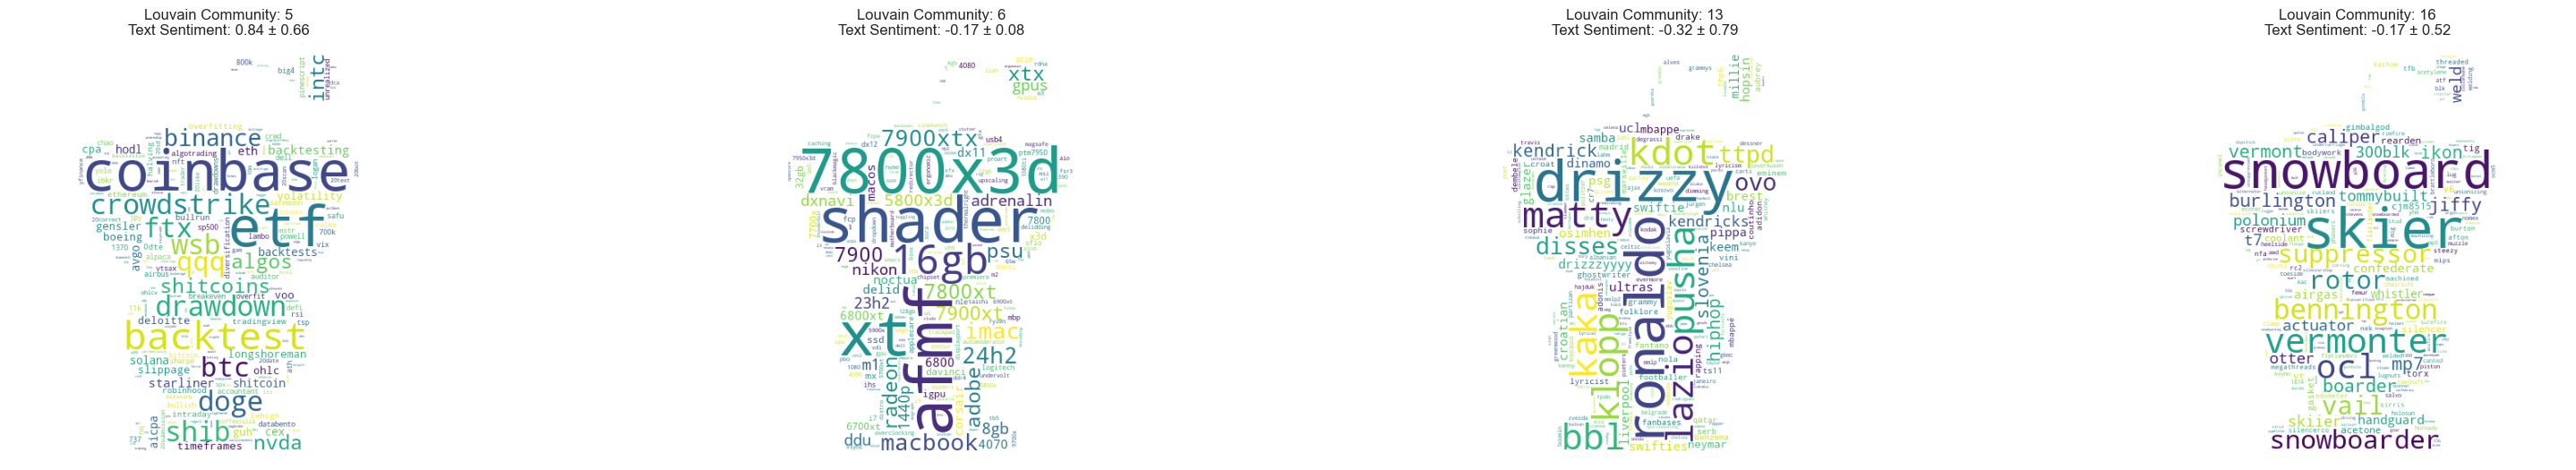

In [54]:
plot_wordclouds("louvain_display", IDF_louvain, mask=mask, sentiment_statistics=sentiment_louvain_statistics)

**So what do the wordclouds tell us?**\
We chose the communities 5,6,13 and 16 to create wordclouds for.\
These communities were chosen as they are some of the largest communities, and based on the sentiment plot they have some variance in the sentiment. i.e. the sentiment doesnt revolve around 0.\
Lets try to interpret the wordclouds.

**Community 5**\
The wordcloud for community 5 is dominated by words like "coinbase", "crowdstrike", "doge", "btc", "backtest" etc. This indicates that the community is likely to be about trading, investing or similar.\ Looking at the confusion matrix this is confirmed, as the community consists of the subreddits `algotrading`, `Accounting`, `CryptoCurrency` and `wallstreetbets`. The sentiment of the community is positive with a sentiment score of 0.84 however the sentiment differs quite alot. This indicates that the community is not homogenous in terms of sentiment.\
**Community 6**\
The wordcloud for community 6 is dominated by words or product number such as "macbook", "adobe", "imac", "shader", "afmf" (AMD Fluid Motion Frames), "16gb", "7800x3d" etc. This indicates that the community is likely to be about technology, computers or similar. Looking at the confusion matrix this is confirmed, as the community consists of the subreddits `Amd`, `mac`, `editors` and `help`. The sentiment of the community is negatice with a sentiment score of -0.17 and the variance is quite low. This indicates that the posts in the community have a tendency to be negative, maybe perhaps because it is questions, that might have negatively connotations.\
**Community 13**\
The penultimate wordcloud contains words/names such as "drizzy" (Drake), (Jürgen) "Klopp", "Kaka", "Ronaldo", "Matty", "kdot" (Kendrick Lamar), "Lazio", "hiphop", "pusha" etc. This is clearly a community that is about rap music and football. Looking at the confusion matrix these are also the subreddits that are grouped together in this community (`soccer` and `rap`). However, that is not the only subreddits in the community, as it also contains the subreddit `TaylorSwift`. This is not clear from the wordcloud, perhaps du to our definitions of TF and IDF. The sentiment of the community is negative with a sentiment score of -0.32 but with a high variance.\
**Community 16**\
The last wordcloud contains words such as "skier", "snowboard", "Vermont", "suppressor", "bennington", "maine", "jiffy", "screwdriver", "torque" etc. This indicates a community about skiing (perhaps in the northern USA), while also containing posts about tools. Looking at the true subreddits in the community, this proves to be correct as the community contains the subreddits `vermont`, `MechanicAdvice`, `NFA` (National Firearms Act), `snowboarding` and `Welding`. The sentiment of the community is negative with a sentiment score of -0.37. Again the variance is quite high.
